In [28]:
using AngularPowerSpectra
using Healpix
using CSV
using Test
using LinearAlgebra
using DataFrames
using DelimitedFiles
using NPZ
import AngularPowerSpectra: TT, TE, EE

using PyCall
hp = pyimport("healpy")

using PyPlot
PyPlot.svg(true);

In [102]:
theory = CSV.read("../test/data/theory.csv", DataFrame)
noise = CSV.read("../test/data/noise.csv", DataFrame)

noise.nltt .*= 4
noise.nlee .*= 4;

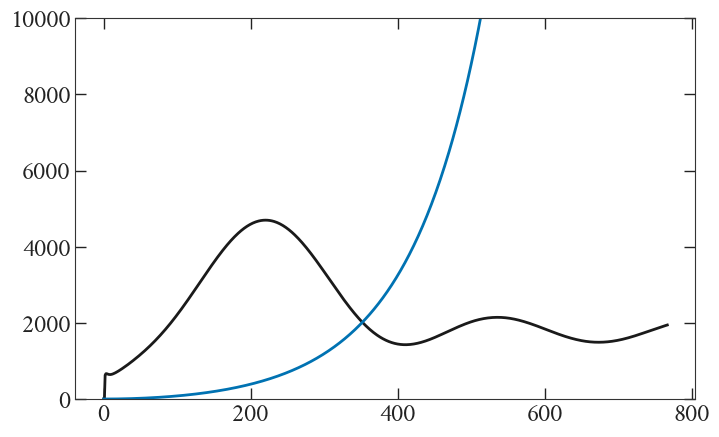

(0.0, 10000.0)

In [103]:
plt.plot(theory.ell, theory.cltt .* theory.ell.^2, "-")
plt.plot(noise.l, noise.nltt .* noise.l.^2, "-")
ylim(0, 1e4)

In [104]:
nside = 256

weight_dir = "/tigress/zequnl/cmb/data/healpy-data/full_weights/"
weights = readfullweights("$(weight_dir)/healpix_full_weights_nside_$(lpad(nside,4,'0')).fits");

In [105]:
mask1 = readMapFromFITS("../test/data/mask1_T.fits", 1, Float64)
mask2 = readMapFromFITS("../test/data/mask2_P.fits", 1, Float64);

In [106]:
lmax = 3nside-1
m1 = PolarizedMap{Float64, RingOrder}(nside)
m2 = PolarizedMap{Float64, RingOrder}(nside);
noise_buffer = Alm(lmax, lmax)
a1 = [Alm(lmax, lmax) for i in 1:3]
a2 = [Alm(lmax, lmax) for i in 1:3];

In [200]:
𝐂 = zeros(1, 1, lmax+1)
𝐍 = zeros(1, 1, lmax+1)

pwT = hp.pixwin(nside)
𝐂[1,1,:] .= theory.cltt .* pwT.^2;
𝐍[1,1,:] .= noise.nltt


function sim!(𝐂, 𝐍, a1, a2, buffer)
    # deposit signal
    synalm!(𝐂, [a1[1]])
    a2[1].alm .= a1[1].alm

    # deposit noise (independent)
    synalm!(𝐍, [buffer])
    a1[1].alm .+= buffer.alm
    synalm!(𝐍, [buffer])
    a2[1].alm .+= buffer.alm
    return nothing
end

sim! (generic function with 1 method)

In [217]:
function fill_sim_array!(𝐂, 𝐍, sims, nside)
    lmax = 3nside-1
    m1 = PolarizedMap{Float64, RingOrder}(nside)
    m2 = PolarizedMap{Float64, RingOrder}(nside)
    noise_buffer = Alm(lmax, lmax)
    a1 = [Alm(lmax, lmax) for i in 1:3]
    a2 = [Alm(lmax, lmax) for i in 1:3]
    
    for i in 1:size(sims,2)
        sim!(𝐂, 𝐍, a1, a2, noise_buffer)
        sims[:,i] .= alm2cl(a1[1], a2[1])
    end
    
    return nothing
end

fill_sim_array! (generic function with 2 methods)

In [219]:
nsims = 50
sim_array = zeros(Float64, (lmax+1, nsims))

fill_sim_array!(𝐂, 𝐍, sim_array, nside)

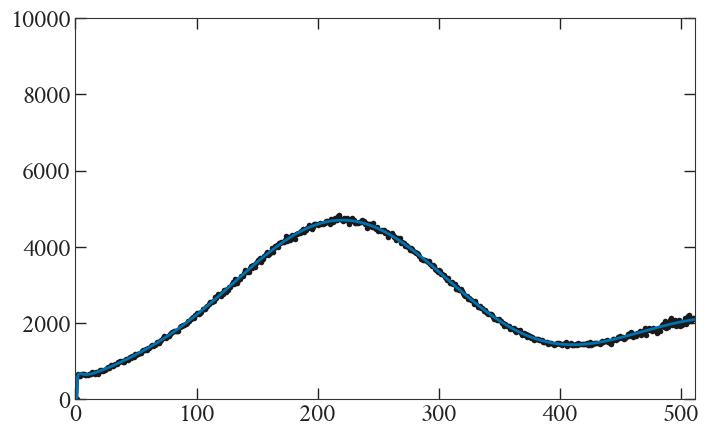

(0.0, 10000.0)

In [225]:
import Statistics: mean, cov
plot(mean(sim_array, dims=2) .* theory.ell.^2  ./ pwT.^2)
plot(theory.ell, theory.cltt .* theory.ell.^2, "-")
xlim(0,2nside)
ylim(0, 1e4)